In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks', color_codes=True)

%matplotlib inline

In [4]:
df = pd.read_csv('data/opv_db.csv.gz')
df = df.drop_duplicates(subset='mol')

In [5]:
df.head()

,mol,ctag,basis,total_energy,optical_lumo,gap,homo,lumo,spectral_overlap,delta_homo,delta_lumo,delta_optical_lumo,homo_extrapolated,lumo_extrapolated,gap_extrapolated,optical_lumo_extrapolated,smile
0,blank\n OpenBabel03101821053D\n\n 54 59 0 0 ...,A82_f2f2R3R3_A37_R3R3,b3lyp/6-31g(d),-2478.290623,-4.114336,1.5274,-5.641736,-3.572038,334.874280,0.120546,0.051702,0.042554,-5.400643,-3.675442,1.2012,-4.199443,CC1Nc2c(csc2C2=C(C(F)(F)F)C3=C4C(=CC(C(F)(F)F)...
1,blank\n OpenBabel03151802573D\n\n 45 49 0 0 ...,A85_f1Rf2f1f1f1_D203_R3,b3lyp/6-31g(d),-2052.769368,-2.006853,3.1595,-5.166353,-1.493361,58.877443,-0.049253,0.143404,0.126153,-5.264859,-1.780169,3.0057,-2.259159,CN1c2ccccc2Sc2ccc(-c3cccc4c3C(F)(F)N(C(F)(F)F)...
2,blank\n OpenBabel03131820523D\n\n106119 0 0 ...,T2_R2_D1_R3R3R0R0_A1_R3R3R0R0R0R0_D1_R3R3R0R0_...,camb3lyp/6-31g,NaN,-3.704025,2.3418,-6.045825,-1.940172,6560.060657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COc1cc2sc(-c3cc4c(C)c5sc(-c6ccc(C7=C8C(=O)N(C)...
3,acc1_A25__D36_R3R3_A3_R3R3__n1 TD-DFT\n OpenBa...,A25__D36_R3R3_A3_R3R3,b3lyp/6-31g(d),NaN,-3.073137,2.2456,-5.318737,-2.673518,792.089714,0.026667,0.123540,0.095633,-5.265403,-2.920598,2.0010,-3.264403,CN.CN.CN1C(=O)c2cn(C)c(CNc3ccc4cc(NCc5cccc6nc7...
4,blank\n OpenBabel03111814573D\n\n 62 69 0 0 ...,D62_R0R0R3R0R0R3_A18_R3R3,b3lyp/6-31g(d),-3017.605039,-3.027123,1.9795,-5.006623,-2.682770,1386.499986,0.187759,0.235923,0.150841,-4.631105,-3.154616,1.3023,-3.328805,Cc1ccc(-c2c3cc(-c4scc5cc6c(cc45)C(=O)[Si](C)(C...


In [4]:
df_b3 = df[df.basis == 'b3lyp/6-31g(d)']
df_camb = df[df.basis == 'camb3lyp/6-31g']

## Quantifying the optimal error rate through duplicated molecules

In [5]:
import itertools

props = ['gap', 'homo', 'lumo', 'spectral_overlap', 'homo_extrapolated',
         'lumo_extrapolated', 'gap_extrapolated', 'optical_lumo_extrapolated']

def iter_duplicates(df_input):
    
    for ismiles, df in df_input[
        df_input.smile.duplicated(keep=False)].groupby('smile'):
        for df1, df2 in itertools.combinations(df.loc[:, props].iterrows(), 2):
            df_1 = df1[1].copy()
            df_1.index += '_1'
            
            df_2 = df2[1].copy()
            df_2.index += '_2'
            
            comb = df_1.append(df_2)
            comb['id_1'] = df1[0]
            comb['id_2'] = df2[0]

            yield comb


duplicates_b3 = pd.DataFrame(iter_duplicates(df_b3))
duplicates_camb = pd.DataFrame(iter_duplicates(df_camb))

In [46]:
duplicates_b3.to_csv('duplicates_b3.csv', index=False)

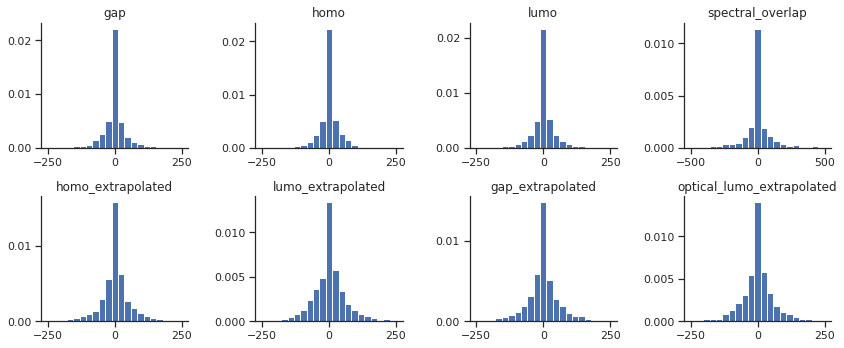

In [44]:
with sns.plotting_context('notebook'):

    fig, axmatrix = plt.subplots(nrows=2, ncols=4, figsize=(12, 5), sharey=False)

    def plot_yx_line(ax):
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]

        ax.plot(lims, lims, '--', color='0.6', zorder=0)

        ax.set_aspect('equal')
        ax.set_adjustable('box')

    for i, (ax, prop) in enumerate(zip(axmatrix.flatten(), props)):
        
        
        prop_df = duplicates_b3.loc[:, [prop + '_1', prop + '_2']].dropna()
        
        
        if prop is not 'spectral_overlap':
            xlim = [-250, 250]
            prop_df *= 1000
            
        else:
            xlim = [-500, 500]
            
        

#         ax.plot(duplicates_b3[prop + '_1'], duplicates_b3[prop + '_2'], 'k.',
#                 ms=1, alpha=.1, rasterized=True)

#         plot_yx_line(ax)

        ax.hist(prop_df.iloc[:, 0] - prop_df.iloc[:, 1], bins=21, range=xlim, density=True)



#         ax.text(1., 0.05, 'MAE: {0:.3f}'.format(mae),
#                 ha='right', va='bottom', transform=ax.transAxes)

        ax.set_title(prop)

    # axmatrix[-1, -1].remove()

    sns.despine()
    plt.tight_layout()
    # plt.savefig('2018_19_04_15_35_duplicated_polymer_prop_results.svg', transparent=True, dpi=200)

/rufous/pstjohn/miniconda3/envs/tf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(array([6.79344848e-06, 3.39672424e-06, 0.00000000e+00, 3.39672424e-06,
        3.39672424e-06, 1.35868970e-05, 2.37770697e-05, 2.37770697e-05,
        1.69836212e-05, 3.39672424e-05, 8.15213817e-05, 8.83148302e-05,
        1.42662418e-04, 2.98911733e-04, 5.16302084e-04, 1.85121471e-03,
        6.58624830e-03, 8.45784336e-04, 3.29482251e-04, 1.66439488e-04,
        8.83148302e-05, 6.11410363e-05, 5.43475878e-05, 3.39672424e-05,
        1.35868970e-05, 1.01901727e-05, 1.69836212e-05, 2.03803454e-05,
        1.01901727e-05, 3.39672424e-06, 6.79344848e-06]),
 array([-1424.38124698, -1336.31624828, -1248.25124959, -1160.18625089,
        -1072.1212522 ,  -984.0562535 ,  -895.99125481,  -807.92625611,
         -719.86125742,  -631.79625872,  -543.73126003,  -455.66626133,
         -367.60126263,  -279.53626394,  -191.47126524,  -103.40626655,
          -15.34126785,    72.72373084,   160.78872954,   248.85372823,
          336.91872693,   424.98372562,   513.04872432,   601.11372301,
      

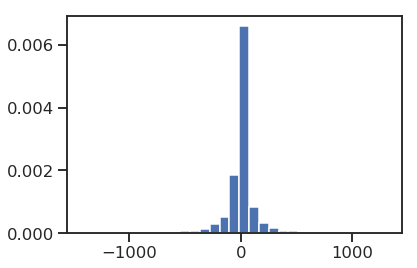

In [42]:
plt.hist((duplicates_b3['spectral_overlap_1'] - duplicates_b3['spectral_overlap_2']).dropna(), bins=31, normed=True)

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error


maes = {}

for i, (ax, prop) in enumerate(zip(axmatrix.flatten(), props)):


    prop_df = duplicates_b3.loc[:, [prop + '_1', prop + '_2']].dropna()

    mae = mean_absolute_error(prop_df.iloc[:, 0], (prop_df.iloc[:, 1]))
    maes[prop] = mae
        

mae_duplicate = pd.Series(maes)
mae_duplicate = mae_duplicate * 1000
mae_duplicate['spectral_overlap'] /= 1000
mae_duplicate.round(1)

gap                          28.0
homo                         22.0
lumo                         25.5
spectral_overlap             81.3
homo_extrapolated            37.4
lumo_extrapolated            45.0
gap_extrapolated             46.3
optical_lumo_extrapolated    42.6
dtype: float64

In [8]:
rmses = {}
for prop in props:
    prop_df = duplicates_camb.loc[:, [prop + '_1', prop + '_2']].dropna()
    rmse = np.sqrt(mean_squared_error(prop_df.iloc[:, 0], (prop_df.iloc[:, 1])))
    rmses[prop] = rmse

rmse_duplicate_camb = pd.Series(rmses)
rmse_duplicate_camb

gap                            0.052270
homo                           0.042762
lumo                           0.041354
spectral_overlap             146.344069
homo_extrapolated              0.076190
lumo_extrapolated              0.067255
gap_extrapolated               0.084188
optical_lumo_extrapolated      0.060318
dtype: float64

# De-duplicate datasets for training on smiles strings

In [9]:
df_b3_dedupe = df_b3.sort_values('total_energy').drop_duplicates('smile', keep='first').drop(['mol'], 1)
df_camb_dedupe = df_camb.sort_values('total_energy').drop_duplicates('smile', keep='first').drop(['mol'], 1)

In [17]:
df_b3_poly = df_b3[df_b3[props].notna().all(1)]

In [18]:
test = df_b3_poly.sample(n=5000, random_state=0)
valid = df_b3_poly[~df_b3_poly.index.isin(test.index)].sample(n=5000, random_state=0)
train = df_b3[~df_b3.index.isin(test.index) & ~df_b3.index.isin(valid.index)].sample(frac=1, random_state=0)

In [19]:
test.to_csv('data/mol_test.csv', index=False)
valid.to_csv('data/mol_valid.csv', index=False)
train.to_csv('data/mol_train.csv', index=False)